# Basic Sequence Analysis Example: Wolves vs Arsenal, 2004-02-07

This workflow uses data sourced from [Statsbomb open data](https://statsbomb.com/what-we-do/hub/free-data/). It aims to identify common events and sequences of events which immediately precede shots (incl goals) and visualise these for the purpose of informing tactics. This example only uses a single game.

[API usage instructions](https://github.com/statsbomb/statsbombpy/tree/master/statsbombpy)<br>

[PrexfixSpan-py](https://github.com/chuanconggao/PrefixSpan-py)<br>

Up the Gunners

In [752]:
#!pip install prefixspan
#!pip install mplsoccer

In [4]:
# import libraries

from mplsoccer.pitch import Pitch
import matplotlib.pyplot as plt
from prefixspan import PrefixSpan
import pandas as pd

In [5]:
# read single match data

match = pd.read_csv('data/match1.csv')

In [6]:
match.head()

,id,index,period,timestamp,minute,second,possession,duration,related_events,off_camera,...,block.offensive,bad_behaviour.card.id,bad_behaviour.card.name,substitution.outcome.id,substitution.outcome.name,substitution.replacement.id,substitution.replacement.name,match_id,competition_id,season_id
0,3b20dc57-5cb7-46a8-bccb-b09d984478d7,1,1,00:00:00.000,0,0,1,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3749052,2,44
1,61306f72-bec9-466f-9d43-c1152531323c,2,1,00:00:00.000,0,0,1,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3749052,2,44
2,98964276-7c4e-4067-975a-2f7a07665ad8,3,1,00:00:00.000,0,0,1,0.000000,691cd9cc-9e81-4ba1-83b9-87fc0617fab0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3749052,2,44
3,691cd9cc-9e81-4ba1-83b9-87fc0617fab0,4,1,00:00:00.000,0,0,1,0.000000,98964276-7c4e-4067-975a-2f7a07665ad8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3749052,2,44
4,3870b202-0c05-4fe2-9729-e186bd4d1808,5,1,00:00:00.675,0,0,2,0.657763,5d182627-e4c7-4c52-883d-e988e72c0b27,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3749052,2,44


In [7]:
match['location']

0                 NaN
1                 NaN
2                 NaN
3                 NaN
4         c(61, 40.1)
            ...      
3513      c(63.2, 31)
3514    c(54.7, 27.5)
3515      c(39, 18.6)
3516              NaN
3517              NaN
Name: location, Length: 3518, dtype: object

In [756]:
# view columns and explore data

#list(match)
col_of_interest='shot.outcome.name'
match[col_of_interest].value_counts()

Off T      11
Saved       5
Goal        4
Blocked     4
Name: shot.outcome.name, dtype: int64

In [757]:
# select required columns

req_cols=['index','type.name','type.id','team.name','player.name','player.id',
          'position.name','shot.statsbomb_xg', 'shot.outcome.name','location', 
          'pass.end_location','carry.end_location']

match_1_events=match[req_cols]

In [758]:
import warnings
warnings.filterwarnings('ignore')

# clean and process
match_1_events['type.id'] = match_1_events['type.id'].astype(str).str.zfill(2)
match_1_events['player.id'] = match_1_events['player.id'].fillna('00000')
match_1_events['player.id'] = match_1_events['player.id'].astype(str).str.split('.', expand=True)[0]

# split locations to X and Y columns
match_1_events[['location_x', 'location_y']] = match_1_events['location'].str.extract(r'c\((.*), (.*)\)').astype(float)
match_1_events[['pass.end_location_x', 'pass.end_location_y']] = match_1_events['pass.end_location'].str.extract(r'c\((.*), (.*)\)').astype(float)
match_1_events[['carry.end_location_x', 'carry.end_location_y']] = match_1_events['carry.end_location'].str.extract(r'c\((.*), (.*)\)').astype(float)

match_1_events = match_1_events.drop(['location', 'pass.end_location', 'carry.end_location'], axis=1)

#remove ball receipts
#match_1_events = match_1_events[match_1_events['type.id'] != '42']
#match_1_events.head()

In [759]:
# add column combining type and player
match_1_events["type_player"] = match_1_events["type.id"].astype(str) + match_1_events["player.id"].astype(str)
match_1_events.head(20)

,index,type.name,type.id,team.name,player.name,player.id,position.name,shot.statsbomb_xg,shot.outcome.name,location_x,location_y,pass.end_location_x,pass.end_location_y,carry.end_location_x,carry.end_location_y,type_player
0,1,Starting XI,35,Wolverhampton Wanderers,NaN,00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3500000
1,2,Starting XI,35,Arsenal,NaN,00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3500000
2,3,Half Start,18,Arsenal,NaN,00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1800000
3,4,Half Start,18,Wolverhampton Wanderers,NaN,00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1800000
4,5,Pass,30,Arsenal,Thierry Henry,15516,Left Center Forward,NaN,NaN,61.0,40.1,61.4,43.6,NaN,NaN,3015516
5,6,Ball Receipt*,42,Arsenal,Dennis Bergkamp,15042,Right Center Forward,NaN,NaN,61.4,43.6,NaN,NaN,NaN,NaN,4215042
6,7,Pass,30,Arsenal,Dennis Bergkamp,15042,Right Center Forward,NaN,NaN,61.9,44.0,46.9,40.8,NaN,NaN,3015042
7,8,Ball Receipt*,42,Arsenal,Eduardo César Daude Gaspar,26014,Left Defensive Midfield,NaN,NaN,46.9,40.8,NaN,NaN,NaN,NaN,4226014
8,9,Carry,43,Arsenal,Eduardo César Daude Gaspar,26014,Left Defensive Midfield,NaN,NaN,46.9,40.8,NaN,NaN,46.9,39.1,4326014
9,10,Pass,30,Arsenal,Eduardo César Daude Gaspar,26014,Left Defensive Midfield,NaN,NaN,46.9,39.1,41.0,6.2,NaN,NaN,3026014


In [760]:
# select only Arsenal events
match_1_ars=match_1_events[match_1_events['team.name']=='Arsenal'].reset_index(drop=True)

In [761]:
# 
match_1_shots=match_1_ars[match_1_ars['type.name']=='Shot']
match_1_shots

,index,type.name,type.id,team.name,player.name,player.id,position.name,shot.statsbomb_xg,shot.outcome.name,location_x,location_y,pass.end_location_x,pass.end_location_y,carry.end_location_x,carry.end_location_y,type_player
211,360,Shot,16,Arsenal,Dennis Bergkamp,15042,Right Center Forward,0.193885,Goal,104.4,34.8,NaN,NaN,NaN,NaN,1615042
293,475,Shot,16,Arsenal,Thierry Henry,15516,Left Center Forward,0.007914,Saved,107.2,18.1,NaN,NaN,NaN,NaN,1615516
296,480,Shot,16,Arsenal,Gilberto Aparecido da Silva,40221,Right Midfield,0.125604,Off T,109.1,50.3,NaN,NaN,NaN,NaN,1640221
427,747,Shot,16,Arsenal,Sulzeer Jeremiah ''Sol' Campbell,15637,Left Center Back,0.043912,Off T,109.1,39.3,NaN,NaN,NaN,NaN,1615637
687,1203,Shot,16,Arsenal,Dennis Bergkamp,15042,Right Center Forward,0.018803,Saved,91.7,39.9,NaN,NaN,NaN,NaN,1615042
860,1491,Shot,16,Arsenal,Dennis Bergkamp,15042,Right Center Forward,0.147070,Saved,109.6,50.3,NaN,NaN,NaN,NaN,1615042
1102,1880,Shot,16,Arsenal,Eduardo César Daude Gaspar,26014,Left Defensive Midfield,0.036048,Off T,100.3,30.5,NaN,NaN,NaN,NaN,1626014
1207,2092,Shot,16,Arsenal,Thierry Henry,15516,Left Center Forward,0.316198,Goal,106.5,49.2,NaN,NaN,NaN,NaN,1615516
1259,2174,Shot,16,Arsenal,Thierry Henry,15516,Left Center Forward,0.018697,Saved,94.5,28.8,NaN,NaN,NaN,NaN,1615516
1289,2219,Shot,16,Arsenal,Kolo Habib Touré,38412,Right Center Back,0.851313,Goal,117.6,39.3,NaN,NaN,NaN,NaN,1638412


In [762]:
# for each 'shot' type.name, create a list of the preceding n events. Append each list to a master list.
# also create a list of event indexes.

shot_events = []
event_indexes = []
for i, row in match_1_ars.iterrows():
    if row['type.name'] == 'Shot':
        start_index = max(0, i - 10)  # Calculate the start index, ensuring it doesn't go below 0
        indexes = list(range(start_index, i))
        event_indexes.extend(indexes)
        single_shot_events=[]
        for j in indexes:
            event=match_1_ars['type_player'][j]
            single_shot_events.append(event)
        shot_events.append(single_shot_events)

In [763]:
# get event data with event indexes
leading_events=match_1_ars.loc[event_indexes]

In [770]:
# use ps algorithm on shot events list of lists.
ps = PrefixSpan(shot_events)

results = ps.frequent(5)

In [771]:
# sort results by support count (desc)
sorted_results = sorted(results, key=lambda x: x[0], reverse=True)
sorted_results

[(8, ['4215516']),
 (6, ['3015515']),
 (5, ['4212529']),
 (5, ['4212529', '4312529']),
 (5, ['4212529', '4312529', '3012529']),
 (5, ['4212529', '3012529']),
 (5, ['4312529']),
 (5, ['4312529', '3012529']),
 (5, ['3012529']),
 (5, ['4215516', '4315516']),
 (5, ['4315516']),
 (5, ['3015516'])]

In [772]:
# select most common event
common_event=sorted_results[0][1][0]
common_event

'4215516'

In [773]:
# find data on all occurences of most common event
common_event_data=leading_events[leading_events['type_player']==common_event].reset_index(drop=True)
common_event_data

,index,type.name,type.id,team.name,player.name,player.id,position.name,shot.statsbomb_xg,shot.outcome.name,location_x,location_y,pass.end_location_x,pass.end_location_y,carry.end_location_x,carry.end_location_y,type_player
0,472,Ball Receipt*,42,Arsenal,Thierry Henry,15516,Left Center Forward,NaN,NaN,103.3,9.4,NaN,NaN,NaN,NaN,4215516
1,472,Ball Receipt*,42,Arsenal,Thierry Henry,15516,Left Center Forward,NaN,NaN,103.3,9.4,NaN,NaN,NaN,NaN,4215516
2,1478,Ball Receipt*,42,Arsenal,Thierry Henry,15516,Left Center Forward,NaN,NaN,89.8,25.9,NaN,NaN,NaN,NaN,4215516
3,1486,Ball Receipt*,42,Arsenal,Thierry Henry,15516,Left Center Forward,NaN,NaN,94.8,27.1,NaN,NaN,NaN,NaN,4215516
4,1869,Ball Receipt*,42,Arsenal,Thierry Henry,15516,Left Center Forward,NaN,NaN,95.5,2.7,NaN,NaN,NaN,NaN,4215516
5,2091,Ball Receipt*,42,Arsenal,Thierry Henry,15516,Left Center Forward,NaN,NaN,111.0,48.9,NaN,NaN,NaN,NaN,4215516
6,2172,Ball Receipt*,42,Arsenal,Thierry Henry,15516,Left Center Forward,NaN,NaN,93.7,26.8,NaN,NaN,NaN,NaN,4215516
7,2207,Ball Receipt*,42,Arsenal,Thierry Henry,15516,Left Center Forward,NaN,NaN,112.8,26.0,NaN,NaN,NaN,NaN,4215516
8,2775,Ball Receipt*,42,Arsenal,Thierry Henry,15516,Left Center Forward,NaN,NaN,79.8,2.8,NaN,NaN,NaN,NaN,4215516


In [774]:
n_shots=len(match_1_shots)
n_common_events=len(common_event_data)
player_name=common_event_data.loc[0]['player.name']
type_name=common_event_data.loc[0]['type.name']
pc_common_event=round((n_common_events/n_shots)*100,2)

print(f"In the match against Wolves, Arsenal had {n_shots} shots. {pc_common_event}% of these were preceeded by a {type_name} by {player_name}.")

In the match against Wolves, Arsenal had 11 shots. 81.82% of these were preceeded by a Ball Receipt* by Thierry Henry.


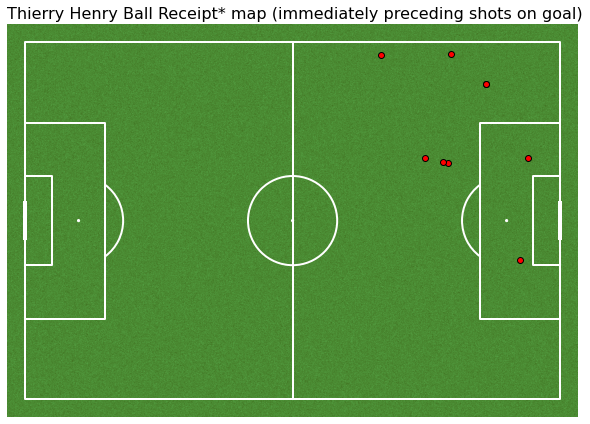

In [775]:
# visualise events

event_id=int(common_event[:2])
pitch = Pitch(pitch_color='grass', line_color='white', stripe=False)
fig, ax = pitch.draw(figsize=(10, 6))

if event_id==42:
    ax.scatter(common_event_data['location_x'], common_event_data['location_y'], color='red', edgecolor='black', zorder=10)
elif event_id==30:
    ax.quiver(common_event_data['location_x'], common_event_data['location_y'], 
             common_event_data['pass.end_location_x'] - common_event_data['location_x'], common_event_data['pass.end_location_y'] - common_event_data['location_y'], 
             color='red', scale_units='xy', angles='xy', scale=1, width=0.005)
elif event_id==43: 
    ax.quiver(common_event_data['location_x'], common_event_data['location_y'], 
             common_event_data['carry.end_location_x'] - common_event_data['location_x'], common_event_data['carry.end_location_y'] - common_event_data['location_y'], 
             color='black', scale_units='xy', angles='xy', scale=1, width=0.005)
ax.set_title(f"{player_name} {type_name} map (immediately preceding shots on goal)", fontsize=16, loc='left')
plt.show()
